# Regressão Logistica

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA # Adicionado para visualização

parkinsons = pd.read_csv('./parkinsons+telemonitoring/parkinsons_updrs.data')

# Analise do dataset

In [4]:
parkinsons.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [5]:
parkinsons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

In [6]:
# --- 1. Preparar o Target (y) para Classificação ---
# O dataset é de regressão, então criamos classes baseadas na gravidade (Mediana)
mediana_updrs = parkinsons['total_UPDRS'].median()
y = (parkinsons['total_UPDRS'] > mediana_updrs).astype(int)

# --- 2. Selecionar as Features (X) ---
# Removemos colunas que não são preditores válidos:
# - 'subject#': Apenas identificador
# - 'test_time': Variável temporal não útil para classificação estática
# - 'motor_UPDRS' e 'total_UPDRS': São as respostas (targets)
colunas_para_remover = ['subject#', 'test_time', 'motor_UPDRS', 'total_UPDRS']

x = parkinsons.drop(colunas_para_remover, axis=1)

# Verificação
print("Shape de X:", x.shape)
print("Distribuição das classes em y:\n", y.value_counts())

Shape de X: (5875, 18)
Distribuição das classes em y:
 total_UPDRS
0    2941
1    2934
Name: count, dtype: int64


# Treinamento Regressão Logistica

Pipe + Treinamento

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Cria um "tubo" de processos: primeiro normaliza, depois treina
# max_iter=1000 dá mais tempo para o modelo encontrar a solução
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000) 
)

# Passa o pipeline inteiro para o cross_val_score em vez de apenas o modelo 'lr'
scores = cross_val_score(pipeline, x, y, cv=10, scoring='accuracy')

print('Acurácia média:', scores.mean())

Acurácia média: 0.5295819861164228


# Dividindo os dados para SVM

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an SVM classifier with a radial basis function (RBF) kernel
svm_classifier = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)

# Train the SVM classifier on the training data
svm_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = svm_classifier.predict(X_test_scaled)

# Evaluate the performance of the SVM classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy:.2f}")

SVM Accuracy: 0.77


# Gráfico usando PCA para diminuir a dimensionalidade

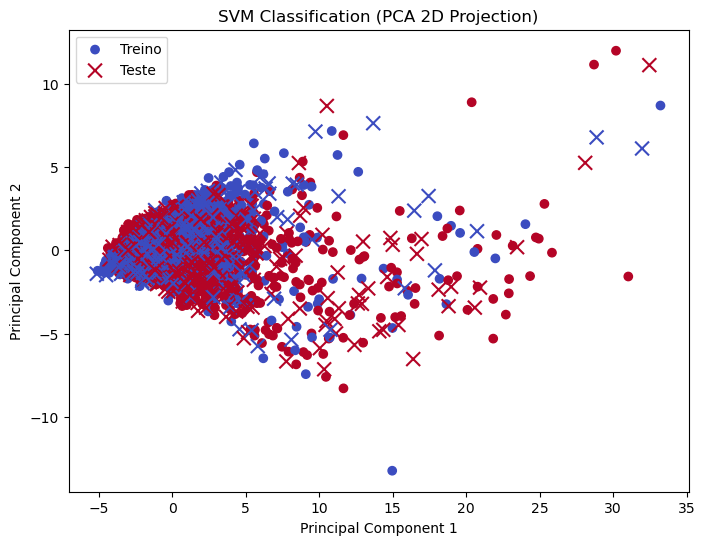

In [10]:
# Como temos muitas features (20+), usamos PCA para reduzir para 3 componentes
# apenas para conseguir visualizar em 2D e 3D.
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Plot the training points (2D - PC1 vs PC2)
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.coolwarm, label='Treino')
# Plot the testing points
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=plt.cm.coolwarm, marker='x', s=100, label='Teste')

plt.title('SVM Classification (PCA 2D Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

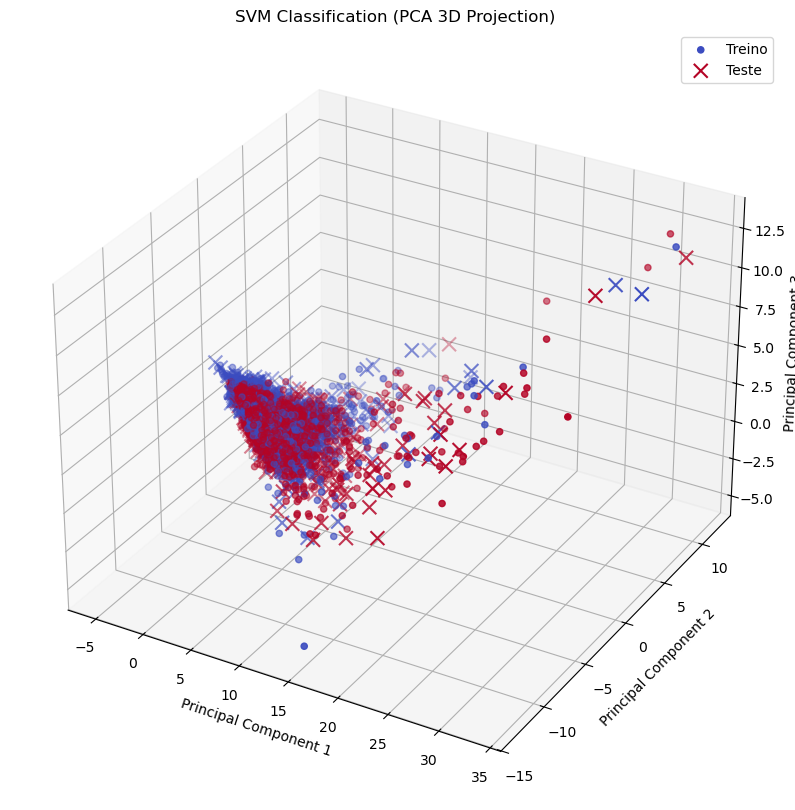

In [11]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap=plt.cm.coolwarm, label='Treino')
ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2], c=y_test, cmap=plt.cm.coolwarm, marker='x', s=100, label='Teste')

plt.title('SVM Classification (PCA 3D Projection)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

Ponto de corte (Mediana): 27.576
Distribuição das Classes:
total_UPDRS
0    2941
1    2934
Name: count, dtype: int64
Iteration 1, loss = 0.66401329
Iteration 2, loss = 0.62235054
Iteration 3, loss = 0.59576882
Iteration 4, loss = 0.56862144
Iteration 5, loss = 0.54339277
Iteration 6, loss = 0.51820550
Iteration 7, loss = 0.49432895
Iteration 8, loss = 0.47992812
Iteration 9, loss = 0.46160423
Iteration 10, loss = 0.44440115
Iteration 11, loss = 0.43308932
Iteration 12, loss = 0.42389285
Iteration 13, loss = 0.41402183
Iteration 14, loss = 0.40545705
Iteration 15, loss = 0.39959029
Iteration 16, loss = 0.39107719
Iteration 17, loss = 0.38725597
Iteration 18, loss = 0.38211153
Iteration 19, loss = 0.37975502
Iteration 20, loss = 0.37411794
Iteration 21, loss = 0.36659436
Iteration 22, loss = 0.36307742
Iteration 23, loss = 0.35933715
Iteration 24, loss = 0.35365130
Iteration 25, loss = 0.34957126
Iteration 26, loss = 0.34998437
Iteration 27, loss = 0.34182447
Iteration 28, loss = 0.34337

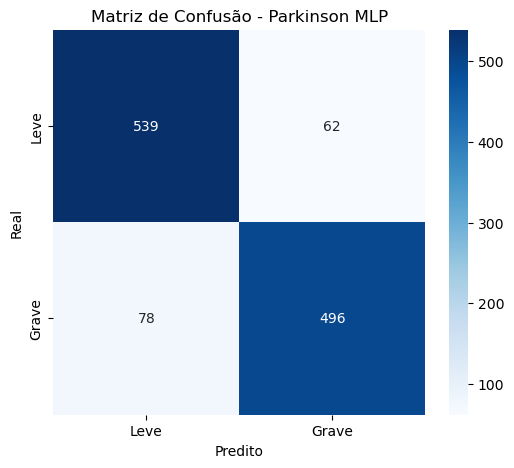

In [13]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# %% [markdown]
# Preparando Target Binário e Features

# %%


# Criar Classe: 1 se for grave (acima da mediana), 0 se for leve
median_updrs = parkinsons['total_UPDRS'].median()
y_val = (parkinsons['total_UPDRS'] > median_updrs).astype(int)

# Features (mesmas da regressão)
X_val = parkinsons.drop(['subject#', 'test_time', 'motor_UPDRS', 'total_UPDRS'], axis=1)

print(f"Ponto de corte (Mediana): {median_updrs}")
print(f"Distribuição das Classes:\n{y_val.value_counts()}")

# Split
X_train, X_test, y_train, y_test = train_test_split(X_val, y_val, test_size=0.2, random_state=42)

# %% [markdown]
# Normalização (Essencial para MLP)

# %%
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# %% [markdown]
# Treinando MLP Classifier

# %%
clf = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42,
    verbose=True
)

clf.fit(X_train, y_train)

# %% [markdown]
# Avaliação

# %%
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Acurácia MLP: {acc:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# %% [markdown]
# Matriz de Confusão

# %%
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Leve', 'Grave'], 
            yticklabels=['Leve', 'Grave'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Parkinson MLP')
plt.show()

Features Selecionadas: ['age', 'sex', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']

Ponto de corte (Mediana UPDRS): 27.576
total_UPDRS
0    2941
1    2934
Name: count, dtype: int64
Acurácia da Árvore: 0.7618

Relatório de Classificação:
               precision    recall  f1-score   support

        Leve       0.79      0.72      0.75       876
       Grave       0.74      0.81      0.77       887

    accuracy                           0.76      1763
   macro avg       0.76      0.76      0.76      1763
weighted avg       0.76      0.76      0.76      1763



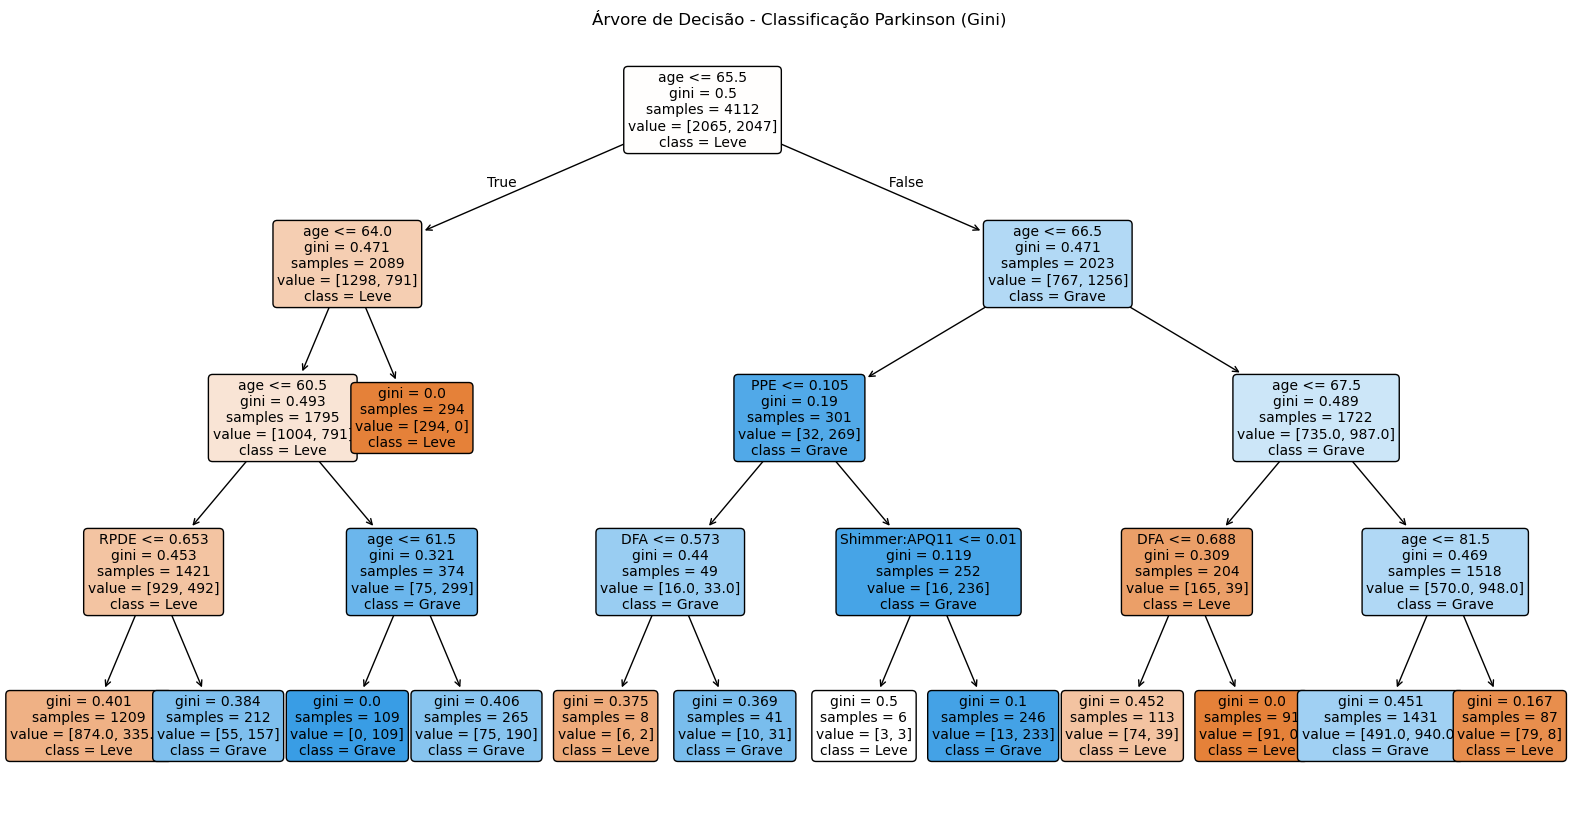

MAE (Erro Médio Absoluto): 5.123287669537885
MSE (Erro Quadrático Médio): 48.8977782269265
RMSE (Raiz do Erro Quadrático): 6.9926946327525625
R2 Score: 0.565276860236153


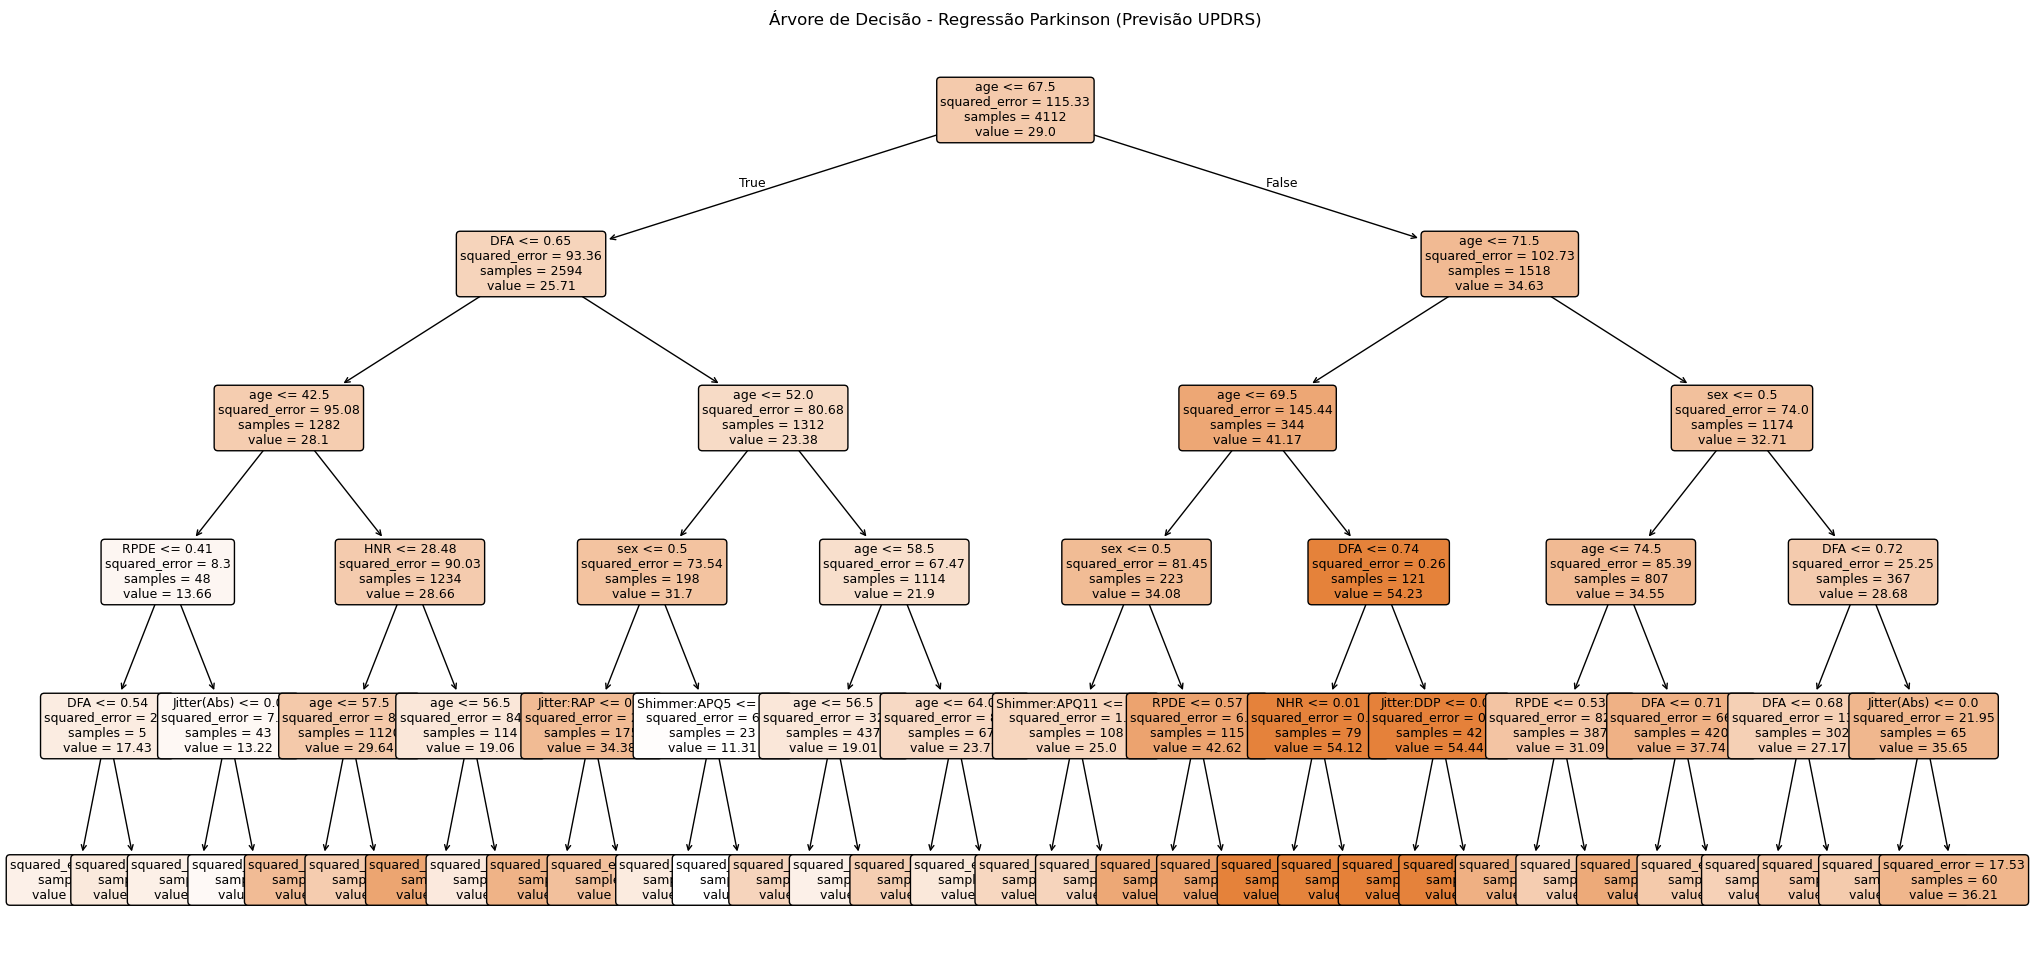

|--- age <= 67.50
|   |--- DFA <= 0.65
|   |   |--- age <= 42.50
|   |   |   |--- RPDE <= 0.41
|   |   |   |   |--- DFA <= 0.54
|   |   |   |   |   |--- value: [15.86]
|   |   |   |   |--- DFA >  0.54
|   |   |   |   |   |--- value: [18.49]
|   |   |   |--- RPDE >  0.41
|   |   |   |   |--- Jitter(Abs) <= 0.00
|   |   |   |   |   |--- value: [15.92]
|   |   |   |   |--- Jitter(Abs) >  0.00
|   |   |   |   |   |--- value: [12.70]
|   |   |--- age >  42.50
|   |   |   |--- HNR <= 28.48
|   |   |   |   |--- age <= 57.50
|   |   |   |   |   |--- value: [34.23]
|   |   |   |   |--- age >  57.50
|   |   |   |   |   |--- value: [28.38]
|   |   |   |--- HNR >  28.48
|   |   |   |   |--- age <= 56.50
|   |   |   |   |   |--- value: [42.16]
|   |   |   |   |--- age >  56.50
|   |   |   |   |   |--- value: [18.22]
|   |--- DFA >  0.65
|   |   |--- age <= 52.00
|   |   |   |--- sex <= 0.50
|   |   |   |   |--- Jitter:RAP <= 0.00
|   |   |   |   |   |--- value: [37.27]
|   |   |   |   |--- Jitter:R

In [15]:
# Remover colunas que não são features de voz ou demográficas úteis para predição direta
# Removemos subject# (ID) e test_time (temporal)
features = parkinsons.drop(['subject#', 'test_time', 'motor_UPDRS', 'total_UPDRS'], axis=1)
feature_names = features.columns.tolist()

print("Features Selecionadas:", feature_names)
parkinsons.head()

# %% [markdown]
# # ---------------------------------------------------------
# # PARTE 1: CLASSIFICAÇÃO
# # Objetivo: Prever se a gravidade é 'Leve' ou 'Grave'
# # ---------------------------------------------------------

# %%
# Criação do Target Binário (Classificação)
median_updrs = parkinsons['total_UPDRS'].median()
y_class = (parkinsons['total_UPDRS'] > median_updrs).astype(int) # 1 = Grave, 0 = Leve
class_names = ['Leve', 'Grave']

print(f"\nPonto de corte (Mediana UPDRS): {median_updrs}")
print(y_class.value_counts())

# Divisão Treino/Teste
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(features, y_class, test_size=0.3, random_state=42)

# %% [markdown]
# <h3>Treinamento (Classificação)</h3>

# %%
# Usando critério Gini e limitando profundidade para visualização
tree_clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=4, 
    random_state=42
)
tree_clf.fit(X_train_c, y_train_c)

# %% [markdown]
# <h3>Avaliação (Classificação)</h3>

# %%
y_pred_c = tree_clf.predict(X_test_c)
acuracia = accuracy_score(y_test_c, y_pred_c)

print(f"Acurácia da Árvore: {acuracia:.4f}")
print("\nRelatório de Classificação:\n", classification_report(y_test_c, y_pred_c, target_names=class_names))

# %% [markdown]
# <h3>Visualização da Árvore (Classificação)</h3>

# %%
plt.figure(figsize=(20, 10))
plot_tree(
    tree_clf,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Árvore de Decisão - Classificação Parkinson (Gini)")
plt.show()

# %% [markdown]
# # ---------------------------------------------------------
# # PARTE 2: REGRESSÃO
# # Objetivo: Prever o valor exato do 'total_UPDRS'
# # ---------------------------------------------------------

# %%
# Target Numérico (Regressão)
y_reg = parkinsons['total_UPDRS']

# Divisão Treino/Teste
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(features, y_reg, test_size=0.3, random_state=42)

# %% [markdown]
# <h3>Treinamento (Regressão)</h3>

# %%
# Usando DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(
    max_depth=5, # Profundidade um pouco maior para capturar nuances numéricas
    random_state=42
)
tree_reg.fit(X_train_r, y_train_r)

# %% [markdown]
# <h3>Avaliação (Regressão)</h3>

# %%
def print_evaluate(real, predicted):
    mae = mean_absolute_error(real, predicted)
    mse = mean_squared_error(real, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(real, predicted)
    
    print("MAE (Erro Médio Absoluto):", mae)
    print("MSE (Erro Quadrático Médio):", mse)
    print("RMSE (Raiz do Erro Quadrático):", rmse)
    print("R2 Score:", r2)
    
y_pred_r = tree_reg.predict(X_test_r)
print_evaluate(y_test_r, y_pred_r)

# %% [markdown]
# <h3>Visualização da Árvore (Regressão)</h3>

# %%
plt.figure(figsize=(25, 12))
plot_tree(
    tree_reg,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    fontsize=9,
    precision=2
)
plt.title("Árvore de Decisão - Regressão Parkinson (Previsão UPDRS)")
plt.show()

# %% [markdown]
# <h3>Regras em Texto (Exemplo Regressão)</h3>

# %%
r = export_text(tree_reg, feature_names=feature_names)
# Imprime apenas os primeiros 1000 caracteres para não poluir demais se a árvore for grande
print(r[:2000])